--------------------------------------------------------
λ=       0.0
a not 0: 50.18%
Error =  0.24
   -preserve information 100.0 %
   -sparseness of a      0.0 %
--------------------------------------------------------
--------------------------------------------------------
λ=       0.0001
a not 0: 50.14%
Error =  0.24
   -preserve information 99.723 %
   -sparseness of a      0.277 %
--------------------------------------------------------
--------------------------------------------------------
λ=       0.001
a not 0: 49.87%
Error =  0.25
   -preserve information 97.31 %
   -sparseness of a      2.69 %
--------------------------------------------------------
--------------------------------------------------------
λ=       0.01
a not 0: 47.41%
Error =  0.3
   -preserve information 78.991 %
   -sparseness of a      21.009 %
--------------------------------------------------------
--------------------------------------------------------
λ=       0.03
a not 0: 42.11%
Error =  0.43
  

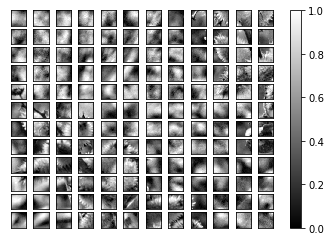

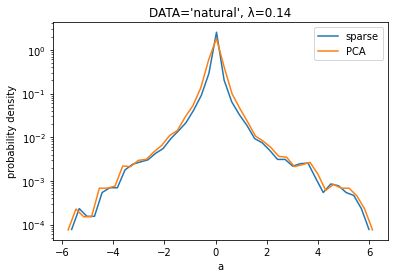

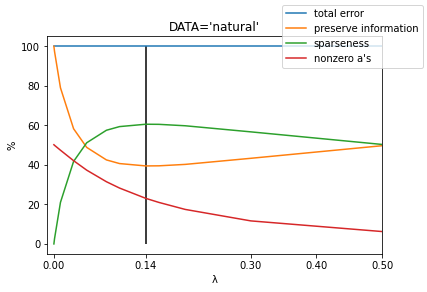

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

DATA = 'natural' # choose 'natural' or 'pixels'

if DATA == 'pixels':
    n1 = 16 # image size is n1 * n1
    N = 1500 # number of images
    n = n1**2
    x = np.zeros([N,n1,n1])
    y = np.random.rand(N,n)
    x = -np.log(y)
    x = np.reshape(x,[N,n1,n1])
    x /= np.max(x) 
    lamda = 0.08    

if DATA == 'natural':
    img = io.imread('/Users/samsuidman/Desktop/neurophysics/advanced_computational_neuroscience/Week 2 Take Home/sampleMerry_0011_Lasalle.jpeg')
    g = color.rgb2gray(img)
#     plt.imshow(g,cmap='gray')
#     plt.savefig('test.png')
    a1,a2 = g.shape
    k = 0
    n1 = 16 
    n = n1**2
    N = int(a1*a2/n) 
    x = np.zeros([N,n1,n1])
    for i in range(int(a1/n1)): 
        for j in range(int(a2/n1)): 
            x[k] = g[i*n1:(i+1)*n1,j*n1:(j+1)*n1]
            k += 1
    x /= np.max(x)
    lamda = 0.16


I = x.reshape(N,n).copy() # reshape x to get I
I -= np.mean(I,axis=0) # I[pictures,pixels]. Substract mean, such that sum of images for each pixel is zero
C0 = np.matmul(np.transpose(I),I)/N # C0[pixels,pixels] 
w,v = np.linalg.eig(C0) # w[features] eigenvalues with orthonormal eigenvectors v[pixels,features] 
K = 25 # amount of features
i_PCA = np.argsort(w)[-K:][::-1] 
phi = np.transpose(v[:,i_PCA]) # phi[features,pixels] 
a_PCA = np.matmul(I,np.transpose(phi)) # a_PCA[pictures,features]
b = np.matmul(I,np.transpose(phi)) # b[pictures,features] = sum( I[pictures,pixels]*phi[features,pixels]^T ) 
C = np.matmul(phi,np.transpose(phi)) # C[features,features] 


lambdas = np.array([0,0.0001,0.001,0.01,0.03,0.05,0.08,0.1,0.14,0.16,0.20,0.3,0.5])
E1_array = np.zeros(len(lambdas))
E2_array = np.zeros(len(lambdas))
a_non_zero = np.zeros(len(lambdas))
for i,lamda in enumerate(lambdas):
    print("--------------------------------------------------------")
    print("λ=      ",lamda)
    a_sparse = np.where(np.abs(b)<=lamda,0,b-lamda*np.sign(b)) # a[pictures,features] # PROBLEM IS HERE!!!!!!! sign(b) SHOULD BE sign(a)
    En = 1/2*np.sum((I-np.matmul(a_sparse,phi))**2,axis=1) + lamda*np.sum(np.abs(a_sparse),axis=1)# calculate error En[pictures]
    E1 = 1/2*np.sum((I-np.matmul(a_sparse,phi))**2,axis=1)
    E2 = lamda*np.sum(np.abs(a_sparse),axis=1)
    E1_mean = np.mean(E1)
    E2_mean = np.mean(E2)
    E = np.mean(En) # mean error between pictures 
    threshold_zero = 0.0001 # if a<error_zero then it is said to be zero
    print( "a not 0: " + str(round((np.sum(np.where(a_sparse>threshold_zero,1,0))/(N*K))*100,2)) + "%" ) 
    print("Error = ",round(E,2))
    print("   -preserve information",round(E1_mean/E*100,3),"%")
    print("   -sparseness of a     ",round(E2_mean/E*100,3),"%")
    print("--------------------------------------------------------")
    E1_array[i] = E1_mean/E
    E2_array[i] = E2_mean/E
    a_non_zero[i] = np.sum(np.where(a_sparse>threshold_zero,1,0))/(N*K)

if DATA == 'natural':
    lamda = 0.14
if DATA == 'pixels':
    lamda = 0.05
a_sparse = np.where(np.abs(b)<=lamda,0,b-lamda*np.sign(b)) # a[pictures,features] 
y_sparse,x_sparse = np.histogram(a_sparse,bins=40,density=True)
x_sparse = (x_sparse+np.mean(np.diff(x_sparse))/2)[:-1]
y_PCA,x_PCA = np.histogram(a_PCA,bins=40,density=True)
x_PCA = (x_PCA+np.mean(np.diff(x_PCA))/2)[:-1]


# plot the data of 16x16 pixels
p = 12
fig,ax = plt.subplots(nrows=p,ncols=p)
for i in range(p):
    for j in range(p):
        if DATA == 'natural':
            ax[i][j].imshow(I[i*int(a2/16)+j,:].reshape(n1,n1),cmap='gray')
        else:
            ax[i][j].imshow(I[i*p+j,:].reshape(n1,n1),cmap='gray')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
fig.subplots_adjust(wspace=0.1, hspace=0.2)
fig.colorbar(plt.cm.ScalarMappable(cmap='gray'),ax=ax)

# plot the histogram of a
fig,ax = plt.subplots()
ax.plot(x_sparse,y_sparse,label="sparse")
ax.plot(x_PCA,y_PCA,label="PCA")
ax.set_yscale("log")
ax.set_title("DATA='{}', λ={}".format(DATA,lamda))
ax.set_xlabel('a')
ax.set_ylabel('probability density')
ax.legend()

# plot for different lambda the error significance and nonzero a's
fig,ax = plt.subplots(ncols=1)
ax.plot(lambdas,np.ones(len(lambdas))*100,label="total error")
ax.plot(lambdas,E1_array*100,label='preserve information')
ax.plot(lambdas,E2_array*100,label='sparseness')
ax.plot(lambdas,a_non_zero*100,label="nonzero a's")
ax.vlines(lamda,ymin=0,ymax=100,color='black')
ax.set_xlim([-0.01,0.5])
ax.set_xticks([0,lamda,0.3,0.4,0.5])
ax.set_xlabel('λ')
ax.set_ylabel('%')
ax.set_title("DATA='{}'".format(DATA))
fig.legend(loc='upper right')


